## **Importing libraries**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from google.colab import drive 
import pylab as py 
import scipy.stats as stats

sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

drive.mount("/content/drive", force_remount = True)
dir = '/content/drive/MyDrive/AML/'

Mounted at /content/drive


Since in the descriptions there are some float values the below function is defined to handle these errors.

In [ ]:
def split2(text):
    try: return text.split()
    except: return 'error'

In [ ]:
def plot_cat(category):
    step = df.groupby(['general_cat','subcat_1'], as_index=False).size()
    step = step[step.general_cat== category]
    sns.catplot(x ='general_cat',y = 'size', data = step, hue = 'subcat_1', kind='bar',aspect=1.5)
    plt.title('Subcat_1 countplot grouped by general_cat')
    
    step = df.groupby(['general_cat','subcat_1'], as_index=False)['price'].mean()
    step = step[step.general_cat== category]
    sns.catplot(x ='general_cat',y = 'price', data = step, hue = 'subcat_1', kind='bar',aspect=1.5)
    plt.title('Average price of subcat_1 grouped by general_cat')
    plt.show()

## **Loading preprocessed dataset**

In [ ]:
df = pd.read_csv(dir+'per_analisi.csv', index_col=0)
df.head()

,name,item_condition_id,brand_name,price,shipping,item_description,general_cat,subcat_1,subcat_2
0,razer blackwidow chroma keyboard,3,Razer,52.0,0,keyboard is great condition works like came bo...,Electronics,Computers & Tablets,Components & Parts
1,ava viv blouse,1,Target,10.0,1,adorable top hint lace key hole pale pink is h...,Women,Tops & Blouses,Blouse
2,acacia pacific tides santorini top,3,Acacia Swimwear,64.0,0,size small straps slightly shortened fit xs be...,Women,Swimwear,Two-Piece
3,girls cheer tumbling bundle,3,Soffe,6.0,1,get three pairs sophie cheer shorts size small...,Sports & Outdoors,Apparel,Girls
4,girls nike pro shorts,3,Nike,19.0,0,girls size small plus green three shorts total,Sports & Outdoors,Apparel,Girls


In [ ]:
print('Dataset shapes:', df.shape)

Dataset shapes: (846426, 9)


The *info* command shows some NaN records produced by special characters that have not been converted correctly into csv value.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 846426 entries, 0 to 846946
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   name               845706 non-null  object 
 1   item_condition_id  846426 non-null  int64  
 2   brand_name         846426 non-null  object 
 3   price              846426 non-null  float64
 4   shipping           846426 non-null  int64  
 5   item_description   845519 non-null  object 
 6   general_cat        846426 non-null  object 
 7   subcat_1           846426 non-null  object 
 8   subcat_2           846426 non-null  object 
dtypes: float64(1), int64(2), object(6)
memory usage: 64.6+ MB


In [ ]:
df.isnull().sum()

name                 720
item_condition_id      0
brand_name             0
price                  0
shipping               0
item_description     907
general_cat            0
subcat_1               0
subcat_2               0
dtype: int64

It's better to remove NaN values from the dataset.

In [ ]:
df.dropna(inplace = True)
df.reset_index(inplace=True, drop=True)

## **The dependent variable: price**

The goal is to predict the price of products by knowing other variables. Looking at the main quantiles we can discover a positively skewed distribution of price.

In [ ]:
df.price.describe()

count    844805.000000
mean         30.922125
std          44.721098
min           3.000000
25%          12.000000
50%          20.000000
75%          34.000000
max        2009.000000
Name: price, dtype: float64

A logarithmic trasformation is required to observe the real distribution of our data points in a more compact way. By doing this we can observe that now the distribution is closer to the gaussian curve yet positively skewed. 

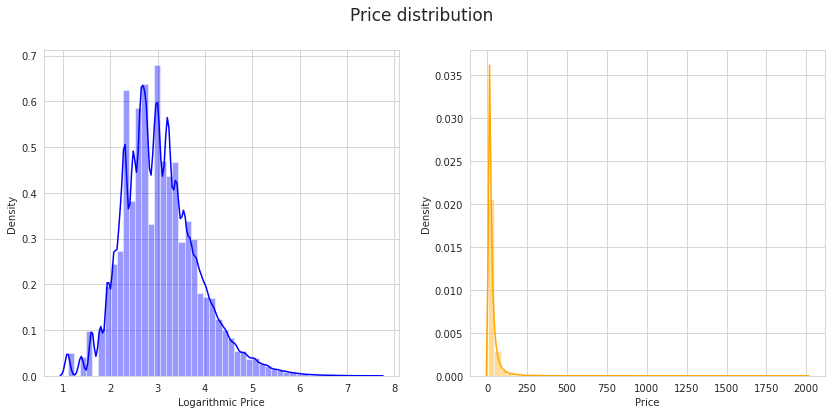

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(14,6))
sns.distplot(x=np.log(df['price']), ax=ax[0], color = 'blue')
ax[0].set_xlabel('Logarithmic Price')
sns.distplot(x=df['price'], ax=ax[1], color = 'orange')
ax[1].set_xlabel('Price')
plt.suptitle('Price distribution', size = 17)
plt.show()

The QQ-plot is also a useful tool in order to understand whether the distribution of the dependent variable is normal (and it is not).

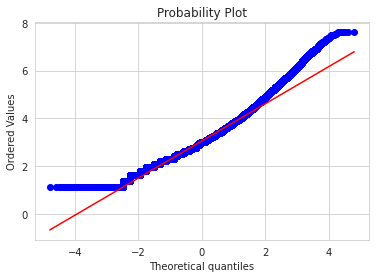

In [ ]:
stats.probplot(np.log(df['price']), dist="norm", plot=plt)
plt.show()

The right tail being heavier means that some outlier might be present.

In [ ]:
print(f'0.95% percentile: {df.price.quantile(0.95)}$')

0.95% percentile: 86.0$


In [ ]:
outliers = df.general_cat[df.price > 86]

As expected "Electronics" is one of the most expensive category.<br>
Products designed for "Women" represent the 50% of the overall outliers. This is due to the presence of many high quality manufactures which make the price "explode". 

In [ ]:
(outliers.value_counts()/len(outliers)*100).to_frame('percentage')

,percentage
Women,49.391652
Electronics,21.833853
Men,13.802710
Kids,5.345365
Vintage & Collectibles,2.826258
Beauty,2.440534
Home,2.219100
Sports & Outdoors,1.657182
Other,0.483345


Data are then grouped regarding the two subcategories: as expected, it is clear that those are strongly connected to the main categories.

In [ ]:
df[df.price > 86].groupby('subcat_1')['price'].mean().sort_values(ascending = False).head(10).to_frame('average_price')

,average_price
subcat_1,
Bags and Purses,302.254372
Computers & Tablets,234.808315
Cameras & Photography,221.598387
Cell Phones & Accessories,210.834435
Strollers,203.645570
Women's Handbags,190.331454
Musical instruments,177.354839
Video Games & Consoles,172.520435
Pregnancy & Maternity,172.333333


In [ ]:
df[df.price > 86].groupby('subcat_2')['price'].mean().sort_values(ascending = False).head(10).to_frame('average_price')

,average_price
subcat_2,
Watch,400.000000
Handbag,340.022371
Pouch,306.000000
Laptops & Netbooks,289.843308
Other Accessories,281.000000
Arts & Crafts,275.000000
Clutch,268.571429
Luggage,262.984615
Wind & Woodwind Instruments,259.000000


## **Independent variables**

### **General categories**

In [ ]:
print('Main category count:', df['general_cat'].nunique())
print('Sub category 1 count:', df['subcat_1'].nunique())
print('Sub category 2 count:', df['subcat_2'].nunique())

Main category count: 10
Sub category 1 count: 104
Sub category 2 count: 669


The function *plot_cat( )* makes easier to explore the count and average price for a given category.

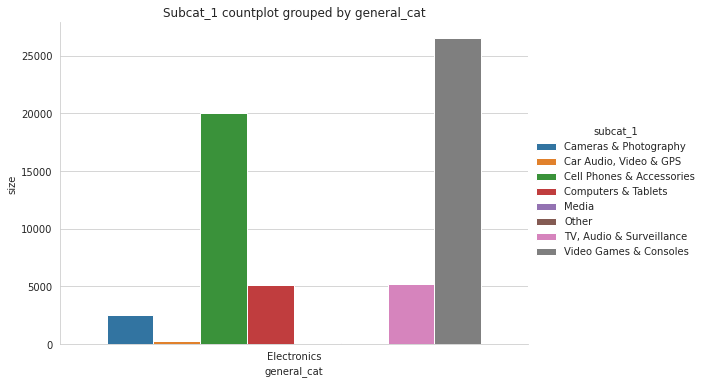

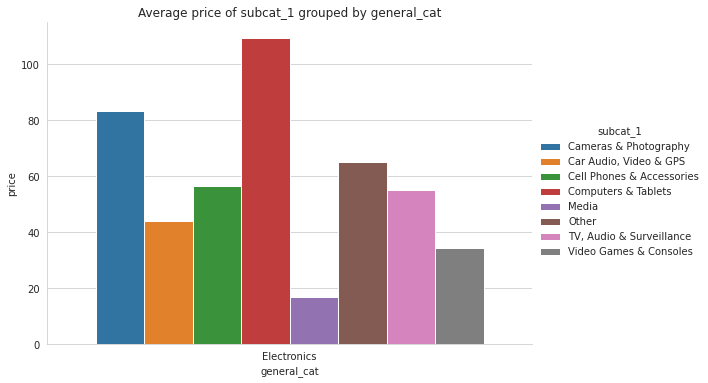

In [ ]:
plot_cat('Electronics')

The variable "general_cat" is obtained in the preprocessing notebook and it distincts products by their main category. Here follows a comparison between the top 10 categories per volume and their prices.

In [ ]:
filter = df['general_cat'].value_counts()

In [ ]:
p1 = df[df.general_cat.isin(filter.index)]

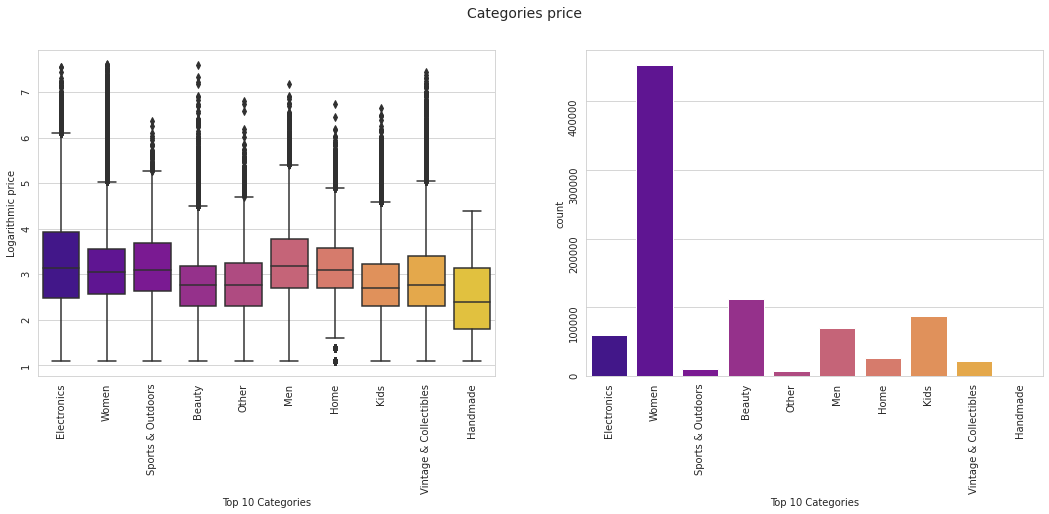

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))
sns.boxplot(x=p1['general_cat'], y=np.log(p1['price']), ax=ax[0], palette = 'plasma')
ax[0].set_ylabel('Logarithmic price')
ax[0].tick_params(labelrotation=90)
ax[0].set_xlabel('Top 10 Categories')

sns.countplot(p1['general_cat'], ax = ax[1], palette = 'plasma')
ax[1].tick_params(labelrotation=90)
ax[1].set_xlabel('Top 10 Categories')
plt.suptitle('Categories price', size = 14)
plt.show()

Electronics present the highest variance within the distribution. It is important to notice that category "women" is by far the most dominant in the dataset.

In [ ]:
(df.general_cat.value_counts()/len(df)).to_frame('percentage')

,percentage
Women,0.535823
Beauty,0.131757
Kids,0.103657
Men,0.083275
Electronics,0.070710
Home,0.031323
Vintage & Collectibles,0.024707
Sports & Outdoors,0.010948
Other,0.007717
Handmade,0.000083


### **Shipping and Item_condition**

Since "shipping" is a dummy variable it is useful to compute the relative frequencies.

In [ ]:
print('Percentage of shipping paid by the sellers:', round(df.shipping.sum()/len(df), 2))

Percentage of shipping paid by the sellers: 0.39


It seems that the price is affected by who pays shipping fees.<br> Actually, the average price is lower for products where fees are paid by the sellers.

In [ ]:
df.groupby('shipping')['price'].mean().to_frame('average_price')

,average_price
shipping,
0,33.346474
1,27.116542


Item_condition_id represents the condition of the products where 1 stands for "new product" and 5 stands for "poor condition". <br>Cumulative frequencies show that more than 95% of the products have an item condition equal or less than 3, hence it is in "good" conditions.

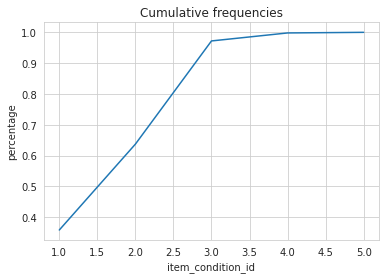

In [ ]:
(df.groupby('item_condition_id').size().cumsum()/len(df)).plot(kind='line')
plt.title('Cumulative frequencies')
plt.ylabel('percentage')
plt.show()

There is almost no correlation between the variables price and item condition, this is due to the high variability of the dataset.

In [ ]:
df[['item_condition_id','price']].corr()

,item_condition_id,price
item_condition_id,1.000000,-0.033797
price,-0.033797,1.000000


### **Brand name**

Most popoular brands on Mercari are products spacing in fashion and clothing field. Electronic products by Apple and Nintendo follow.

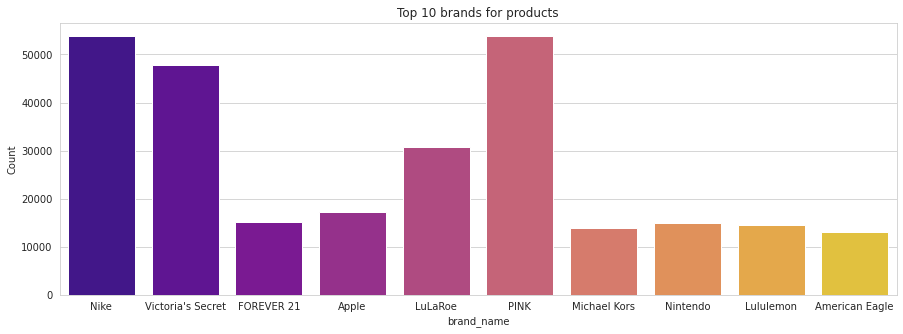

In [ ]:
idx = df.brand_name.value_counts().head(10).index
x = df[df.brand_name.isin(idx)]
plt.figure(figsize=(15, 5))
sns.countplot(x = x['brand_name'], palette = 'plasma')
plt.title('Top 10 brands for products')
plt.ylabel('Count')
plt.show()

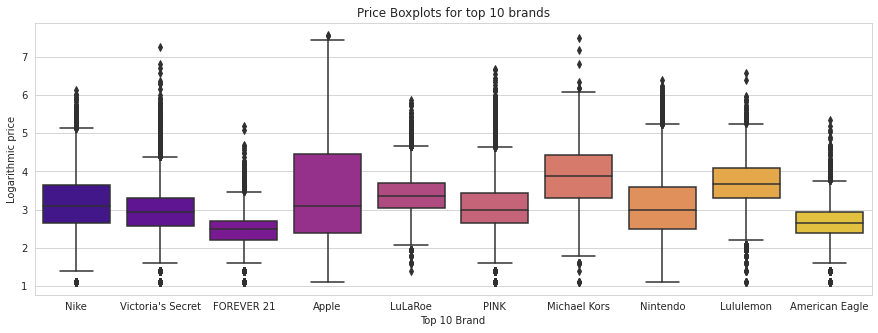

In [ ]:
step = df.brand_name.value_counts().head(10).index
x = df[df.brand_name.isin(step)]
plt.figure(figsize=(15, 5))
sns.boxplot(x=x['brand_name'],y = np.log(x['price']), palette='plasma')
plt.title('Price Boxplots for top 10 brands')
plt.xlabel('Top 10 Brand')
plt.ylabel('Logarithmic price')
plt.show()

Looking at the logarithmic price distribution for those brands, we can spot a lot of outliers for almost every top brand, with Apple being the exception.<br> Apple has also the highest variance since it offers a different and wider range of products while Michael Kors achieves the highest median betweeen the different brands.

### **Text variables**

It is useful to tokenize every textual variable (name and item description) and have an overview of the length of each sentence's tokens list.

In [ ]:
description = df.item_description.apply(split2)
description.apply(len).idxmax()

48271

For instance, in the cell below it's pasted the longest sentence of the database and it is just a meaningless spam of keywords.<br>It is important to understand which words have to be taken into account when considering the embedding phase.

In [ ]:
df.item_description[description.apply(len).idxmax()]

'items rm ea items rm ea mugs yum teacher mr mrs hubby wifey colored interiors mom dad is red red black blessed tea tea blue interior crazy happy birthday yellow interior happy birthday green int r enjoy honey hustle grad imagine sing yasss can not bff big little hey girl fleek wisdom namaste grandpa grandma be bae dad dad favorite caffeine not caffeine wish flawless love strength harmony patience ugh yolo friend woke like bliss chill darling coffee bowls good morning r int r mr mrs enjoy b int r chow ramen eat y int r cereal b int r let eat b int r bliss r int r blessed namaste smile sunshine y int r relax b int r wake sweet let eat white int r yum please tasty happy love hey girl giddy fresh bon appetite cereal good morning home r int r message order limit type per order quantities limited'

In [ ]:
text_count = description.apply(len).to_frame('count_')

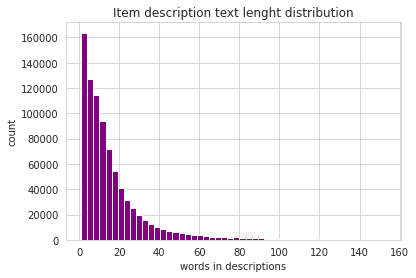

In [ ]:
text_count.hist(bins = 50, color = 'purple')
plt.title('Item description text lenght distribution')
plt.ylabel('count')
plt.xlabel('words in descriptions')
plt.show()

In [ ]:
text_count.describe()

,count_
count,844805.000000
mean,16.172316
std,16.982820
min,1.000000
25%,6.000000
50%,11.000000
75%,20.000000
max,153.000000


A good number of words to be considered can be between 20 and 30 since it would cover more than 75% of the products full descriptions.

### **Product name**

The same process is applied to the products names variable.

In [ ]:
name_count = df.name.apply(split2).apply(len).to_frame('count_')

In [1]:
name_count.hist(bins = 50, color = 'purple')
plt.title('Item description text lenght distribution')
plt.ylabel('count')
plt.xlabel('words in descriptions')
plt.show()

NameError: ignored

In [ ]:
name_count.describe()

,count_
count,844805.000000
mean,3.970070
std,1.445772
min,1.000000
25%,3.000000
50%,4.000000
75%,5.000000
max,11.000000


Looking at the output, since the number of words used to describe each product is not that high we can choose to take 8 as the maximum number of tokens to consider.